<a href="https://colab.research.google.com/github/bnv20/cakd3/blob/main/using_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `Embedding` 층을 사용해 단어 임베딩 학습하기

단어와 밀집 벡터를 연관짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다. 이 방식의 문제점은 임베딩 공간이 구조적이지 않다는 것입니다. 예를 들어 accurate와 exact 단어가 대부분 문장에서 비슷한 의미로 사용되지만 완전히 다른 임베딩을 가지게 됩니다. 심층 신경망이 이런 임의의 구조적이지 않은 임베딩 공간을 이해하기는 어렵습니다.

단어 벡터 사이에 조금 더 추상적이고 기하학적인 관계를 얻으려면 단어 사이에 있는 의미 관계를 반영해야 합니다. 단어 임베딩은 언어를 기하학적 공간에 매핑하는 것입니다. 예를 들어 잘 구축된 임베딩 공간에서는 동의어가 비슷한 단어 벡터로 임베딩될 것입니다. 일반적으로 두 단어 벡터 사이의 거리(L2 거리)는 이 단어 사이의 의미 거리와 관계되어 있습니다(멀리 떨어진 위치에 임베딩된 단어의 의미는 서로 다르고 반면 비슷한 단어들은 가까이 임베딩됩니다). 거리외에 임베딩 공간의 특정 방향도 의미를 가질 수 있습니다.

[...]

실제 단어 임베딩 공간에서 의미 있는 기하학적 변환의 일반적인 예는 '성별' 벡터와 '복수(plural)' 벡터입니다. 예를 들어 'king' 벡터에 'female' 벡터를 더하면 'queen' 벡터가 됩니다. 'plural' 벡터를 더하면 'kings'가 됩니다. 단어 임베딩 공간은 전형적으로 이런 해석 가능하고 잠재적으로 유용한 수천 개의 벡터를 특성으로 가집니다.

사람의 언어를 완벽하게 매핑해서 어떤 자연어 처리 작업에도 사용할 수 있는 이상적인 단어 임베딩 공간이 있을까요? 아마도 가능하겠지만 아직까지 이런 종류의 공간은 만들지 못했습니다. 사람의 언어에도 그런 것은 없습니다. 세상에는 많은 다른 언어가 있고 언어는 특정 문화와 환경을 반영하기 때문에 서로 동일하지 않습니다. 실제로 좋은 단어 임베딩 공간을 만드는 것은 문제에 따라 크게 달라집니다. 영어로 된 영화 리뷰 감성 분석 모델을 위한 완벽한 단어 임베딩 공간은 영어로 된 법률 문서 분류 모델을 위한 완벽한 임베딩 공간과 다를 것 같습니다. 특정 의미 관계의 중요성이 작업에 따라 다르기 때문입니다.

따라서 새로운 작업에는 새로운 임베딩을 학습하는 것이 타당합니다. 다행히 역전파를 사용해 쉽게 만들 수 있고 케라스를 사용하면 더 쉽습니다. `Embedding` 층의 가중치를 학습하면 됩니다.

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 20 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용)

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=max_features)

print(x_train[0])
x_train.shape



17473536/17464789 [==============================] - 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,

(25000,)

In [ ]:
# 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환
x_train = preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
x_train[0]

array([  65,   16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,
        113,  103,   32,   15,   16, 5345,   19,  178,   32], dtype=int32)

In [ ]:
x_train.shape

(25000, 20)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000,8,input_length=maxlen))
# Embedding 층의 출력 크기는 (samples, maxlen, 8)
model.add(Flatten())

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 4s 3ms/step - loss: 0.6682 - acc: 0.6210 - val_loss: 0.6203 - val_acc: 0.6874
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5447 - acc: 0.7461 - val_loss: 0.5316 - val_acc: 0.7286
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4636 - acc: 0.7879 - val_loss: 0.5029 - val_acc: 0.7436
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4216 - acc: 0.8083 - val_loss: 0.4954 - val_acc: 0.7524
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3924 - acc: 0.8249 - val_loss: 0.4964 - val_acc: 0.7526
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3684 - acc: 0.8389 - val_loss: 0.4996 - val_acc: 0.7534
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3468 - acc: 0.8509 - val_loss: 0.5053 - val_acc: 0.7566
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.

75% 정도의 검증 정확도.
리뷰에서 20개의 단어만 사용한 것을 감안하면 양호
입력 시퀀스에 있는 각 단어를 독립적으로 다룸

Glove 단어 임베딩 다운로드

In [1]:
!pwd

/content


In [2]:
!mkdir datasets
!ls

datasets  drive  sample_data


In [3]:
%cd datasets/

/content/datasets


In [4]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-10-26 00:16:07--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-26 00:16:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  3.17MB/s    in 3m 40s  

2021-10-26 00:19:48 (3.73 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [5]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt


In [ ]:
!mkdir /content/drive/MyDrive/cakd3_colab/dl_keras/datasets/glove-6b/

In [6]:
!cp ./glove.6B.100d.txt /content/drive/MyDrive/cakd3_colab/dl_keras/datasets/glove-6b/

In [10]:
import os

imdb_dir = '/content/drive/MyDrive/cakd3_colab/dl_keras/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name,fname), encoding='utf8')
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200 
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


69272개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (14962, 100)
레이블 텐서의 크기: (14962,)


In [12]:
import numpy as np
import os
glove_dir = '/content/drive/MyDrive/cakd3_colab/dl_keras/datasets/glove-6b/'

embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'), encoding='utf8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.'% len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():  
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [15]:
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 110ms/step - loss: 1.8775 - acc: 0.4800 - val_loss: 0.6925 - val_acc: 0.5216
Epoch 2/10
7/7 [==============================] - 0s 81ms/step - loss: 0.5755 - acc: 0.7150 - val_loss: 0.7094 - val_acc: 0.5269
Epoch 3/10
7/7 [==============================] - 1s 83ms/step - loss: 0.5541 - acc: 0.6850 - val_loss: 0.6850 - val_acc: 0.5475
Epoch 4/10
7/7 [==============================] - 0s 80ms/step - loss: 0.4121 - acc: 0.8050 - val_loss: 0.8198 - val_acc: 0.5289
Epoch 5/10
7/7 [==============================] - 0s 82ms/step - loss: 0.3796 - acc: 0.8300 - val_loss: 0.7181 - val_acc: 0.5580
Epoch 6/10
7/7 [==============================] - 0s 82ms/step - loss: 0.2059 - acc: 0.9350 - val_loss: 1.1382 - val_acc: 0.5192
Epoch 7/10
7/7 [==============================] - 0s 79ms/step - loss: 0.1643 - acc: 0.9450 - val_loss: 1.0418 - val_acc: 0.4943
Epoch 8/10
7/7 [==============================] - 0s 80ms/step - loss: 0.0837 - acc: 0.9950 - va

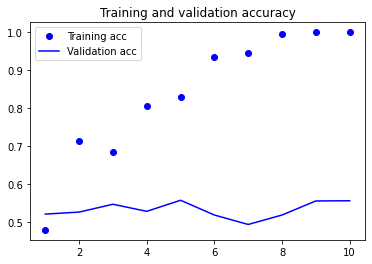

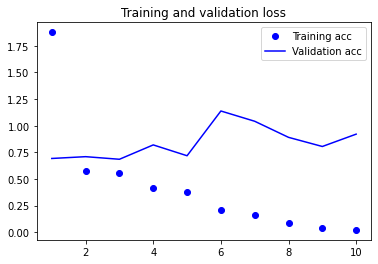

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and validation loss')
plt.legend()